In [ ]:
# Global packages
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import models, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

from google.colab import drive

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading in the Dataset

In [ ]:
normalize = transforms.Normalize(
    mean=[0.3322, 0.0275, 0.1132],
    std=[0.2215, 0.0965, 0.3152],
)

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
])

# Load the dataset
dataset = datasets.ImageFolder("../Dataset_BUSI_with_GT/", transform=transform)

# Get the labels from the dataset
labels = np.array(dataset.targets)

# Split the dataset into train and test sets while maintaining class proportions
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=labels)

# Create Subset datasets for train and test
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Creating Optimizer
Currently the optimizer is an Adam Optimizer

In [ ]:
def create_optimizer(model,  # Function that creates an optimizer for a given model and hyperparameters
                    learning_rate_pretrained=0.00039710,  # Learning rate for pretrained layers
                    learning_rate_new=0.00083336,  # Learning rate for new layers
                    weight_decay=0.0073691,  # Weight decay (L2 regularization) coefficient
                    beta1=0.9,  # Exponential decay rate for the first moment estimates (Adam parameter)
                    beta2=0.999,  # Exponential decay rate for the second moment estimates (Adam parameter)
                    eps=1e-8,  # Small constant to prevent division by zero (Adam parameter)
                    amsgrad=False):  # Flag for using the AMSGrad variant of Adam optimizer

    # Separate model parameters into two groups: pretrained and new
    params_pretrained = []  # Parameters from the pretrained layers
    params_new = []         # Parameters from the new layers

    for name, param in model.named_parameters():
        if 'classifier.6' in name:
            params_new.append(param)  # Parameters from the new layers
        else:
            params_pretrained.append(param)  # Parameters from the pretrained layers

    '''Setting Loss Functions and Optimizers'''
    # Create an Adam optimizer with different learning rates for the two parameter groups
    optimizer = optim.Adam([
        {'params': params_pretrained, 'lr': learning_rate_pretrained},  # Pretrained layer parameters with specific learning rate
        {'params': params_new, 'lr': learning_rate_new},                # New layer parameters with different learning rate
    ], weight_decay=weight_decay, betas=(beta1, beta2), eps=eps, amsgrad=amsgrad)

    return optimizer

# Train and Test Functions

In [ ]:
def training(model, device, train_loader, criterion, optimizer):

    model.to(device)
    model.train()

    train_loss, total_samples = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        # Calculation train loss
        train_loss += loss.item() * images.size(0)
        total_samples += labels.size(0)

    # Calculate average train loss
    avg_train_loss = train_loss / total_samples

    return avg_train_loss

# Evaluation
def testing(model, device, test_loader, criterion, last_epoch=False):

    # Set model to configured device
    model.to(device)
    model.eval()

    test_loss, total_samples = 0.0, 0
    all_predicted_labels = []
    all_predicted_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels.unsqueeze(1).float())

            predicted_probs = torch.sigmoid(outputs)
            all_predicted_probs.extend(predicted_probs.cpu().numpy())

            predicted_labels = (predicted_probs >= 0.4).float()
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

            all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    # Calculate average val loss
    avg_test_loss = test_loss / total_samples

    return avg_test_loss, f1_score(all_labels, all_predicted_labels, average='micro'), all_labels, all_predicted_probs


# Hyperparameters

In [ ]:

'''Setting training parameters'''
num_frozen_layers = 5
num_epochs = 20 # epochs
batch_size = 32 # batch size
k=5 # fold number

loss_results={'train_loss': [],
              'test_loss': []} # dictionary to memorize all the scores
roc_auc_scores = []
fpr_list = []
tpr_list = []

skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # sklearn library

'''Setting Loss Function'''
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for multi-class classification

# Training the Model


In [ ]:
train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=train_subsampler,
)

test_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=test_subsampler,
)

# Initiate the VGG16
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features=4096, out_features=1)

# Freezing some layers
for layer in model.features[:num_frozen_layers]:
    for param in layer.parameters():
        param.requires_grad = False

# Initiating our optimizer
optimizer = create_optimizer(model)

# Iterative epochs
for epoch in range(num_epochs):
    # Train and Val
    avg_train_loss = training(model, device, train_loader, criterion, optimizer)
    avg_test_loss, f1, all_labels, all_predicted_probs = testing(model, device, test_loader, criterion, last_epoch=True)


    print("Epoch:{}/{} AVG Training Loss:{:.6f} AVG Val Loss:{:.6f} F1 Score: {:.6f}".format(epoch + 1, num_epochs, avg_train_loss, avg_test_loss, f1))

    loss_results['train_loss'].append(avg_train_loss)
    loss_results['test_loss'].append(avg_test_loss)

    roc_auc = roc_auc_score(all_labels, all_predicted_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_predicted_probs)

    roc_auc_scores.append(roc_auc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]


Epoch:1/20 AVG Training Loss:0.568570 AVG Val Loss:0.142273 F1 Score: 0.946154
Epoch:2/20 AVG Training Loss:0.228318 AVG Val Loss:0.119302 F1 Score: 0.953846
Epoch:3/20 AVG Training Loss:0.129081 AVG Val Loss:0.181235 F1 Score: 0.961538
Epoch:4/20 AVG Training Loss:0.196074 AVG Val Loss:0.132063 F1 Score: 0.969231
Epoch:5/20 AVG Training Loss:0.078173 AVG Val Loss:0.134545 F1 Score: 0.969231
Epoch:6/20 AVG Training Loss:0.030754 AVG Val Loss:0.376957 F1 Score: 0.938462
Epoch:7/20 AVG Training Loss:0.031331 AVG Val Loss:0.130223 F1 Score: 0.969231
Epoch:8/20 AVG Training Loss:0.021522 AVG Val Loss:0.176311 F1 Score: 0.953846
Epoch:9/20 AVG Training Loss:0.072541 AVG Val Loss:0.159545 F1 Score: 0.953846
Epoch:10/20 AVG Training Loss:0.052266 AVG Val Loss:0.528060 F1 Score: 0.838462
Epoch:11/20 AVG Training Loss:0.086416 AVG Val Loss:0.293281 F1 Score: 0.938462
Epoch:12/20 AVG Training Loss:0.165851 AVG Val Loss:0.130979 F1 Score: 0.961538
Epoch:13/20 AVG Training Loss:0.038988 AVG Val Lo

# Graphing
plt.figure() plt.plot(range(1, num_epochs + 1), loss_results['train_loss'], label='Training Loss') plt.plot(range(1, num_epochs + 1), loss_results['test_loss'], label='Validation Loss') plt.xlabel('Epoch') plt.ylabel('Loss') plt.title('Training and Validation Loss') plt.legend() plt.show()

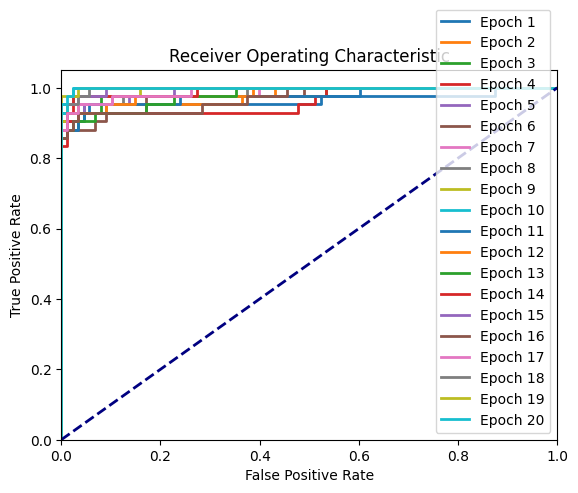

In [ ]:
plt.figure()
for epoch in range(num_epochs):
    plt.plot(fpr_list[epoch], tpr_list[epoch], lw=2, label=f'Epoch {epoch + 1}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./roc_curves.png')  # Save the plot as an image file